In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sn

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams["figure.figsize"] = [16,9]

In [3]:
main_df = pd.read_csv('sensor_features_lstm_tuned.csv', header=None)
print(main_df)

         0         1         2   ...        58        59        60
0       1.0 -0.587281  0.080840  ...  0.875600 -0.713049 -0.901338
1       1.0 -0.599231  0.085383  ...  0.879463 -0.717051 -0.901247
2       1.0 -0.599304  0.085088  ...  0.879690 -0.717256 -0.901344
3       1.0 -0.599482  0.085825  ...  0.879064 -0.716473 -0.901102
4       1.0 -0.598702  0.086125  ...  0.878156 -0.715755 -0.900927
...     ...       ...       ...  ...       ...       ...       ...
11768  17.0 -0.125139  0.138356  ...  0.154357  0.170380 -0.740727
11769  17.0 -0.191166  0.242036  ...  0.105141  0.076240 -0.694695
11770  17.0 -0.072179  0.527310  ...  0.135006 -0.056794 -0.656743
11771  17.0 -0.225445  0.285405  ...  0.181509  0.008481 -0.726518
11772  17.0 -0.176922  0.091612  ...  0.021946  0.179409 -0.658383

[11773 rows x 61 columns]


In [4]:
main_df.iloc[:,1:] = StandardScaler().fit_transform(main_df.iloc[:,1:].to_numpy())

In [5]:
activity_data = main_df.iloc[:, 0].values.astype('int32')
activity_data.shape

(11773,)

In [6]:
sensor_data = main_df.iloc[:,1:].values.astype('float32')
sensor_data.shape

(11773, 60)

In [7]:
model = TSNE(n_components=2, n_iter=3000, perplexity=100, random_state=23, n_jobs=-1)
tsne_data = model.fit_transform(sensor_data)
tsne_data.shape

(11773, 2)

In [8]:
final_data = np.append(activity_data.reshape(-1, 1), tsne_data, axis=1)
final_data.shape

(11773, 3)

In [9]:
# _3D plotting
# tsne_df = pd.DataFrame(final_data, columns=['activity_id', 'X', 'Y', 'Z'])
# figure = plt.figure(figsize=(9,9))
# axes = figure.add_subplot(111,projection = "3d")
# dots = axes.scatter(xs = tsne_df.to_numpy()[:,1],ys = tsne_df.to_numpy()[:,2],zs = tsne_df.to_numpy()[:,3],
#                    c = tsne_df.to_numpy()[:,0], cmap = plt.cm.get_cmap("nipy_spectral_r",10))
# plt.show()

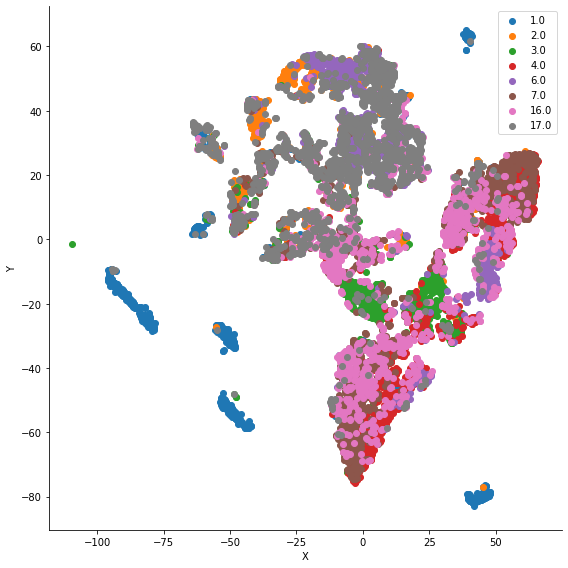

In [10]:
# _2D plotting
tsne_df = pd.DataFrame(final_data, columns=['activity_id', 'X', 'Y'])
sn.FacetGrid(tsne_df, hue='activity_id', height=8).map(plt.scatter, 'X', 'Y')
plt.legend(loc="upper right")
plt.show()

In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [12]:
def generate_words(cluster_cnts):
    
    prefix = 'W_'
    return [prefix+str(val) for val in range(1, cluster_cnts+1)]

In [13]:
def generate_cluster_words(seq_clusters, cluster_words):
    
    # _assign word to each cluster of the subsequence usnig numpy where function
    assigned_words = np.where(seq_clusters != 0, seq_clusters, cluster_words[0])
    for idx in range(1, len(cluster_words)):
         assigned_words = np.where(seq_clusters != idx, assigned_words, cluster_words[idx])
            
    return assigned_words

In [14]:
tsne_df.iloc[:,1:] = StandardScaler().fit_transform(tsne_df.iloc[:,1:].to_numpy())
tsne_data = tsne_df.iloc[:,1:].values.astype('float32')

In [15]:
for val in range(10, 101, 5):
  gmm = GaussianMixture(n_components=val, random_state=2).fit(tsne_data)
  cluster = gmm.predict(tsne_data)
  sc = silhouette_score(tsne_data, cluster)
  print(f'cluster count: {val}, sc: {sc}')
#gmm.means_

cluster count: 10, sc: 0.43137916922569275
cluster count: 15, sc: 0.414841890335083
cluster count: 20, sc: 0.4419899582862854
cluster count: 25, sc: 0.4398450255393982
cluster count: 30, sc: 0.4108375012874603
cluster count: 35, sc: 0.41432279348373413
cluster count: 40, sc: 0.45690807700157166
cluster count: 45, sc: 0.4422503411769867
cluster count: 50, sc: 0.4494650959968567
cluster count: 55, sc: 0.45134153962135315
cluster count: 60, sc: 0.44288551807403564
cluster count: 65, sc: 0.4345531761646271
cluster count: 70, sc: 0.42546388506889343
cluster count: 75, sc: 0.4263933300971985
cluster count: 80, sc: 0.4347909092903137
cluster count: 85, sc: 0.42420193552970886
cluster count: 90, sc: 0.4370962083339691
cluster count: 95, sc: 0.43556177616119385
cluster count: 100, sc: 0.4380547106266022


In [16]:
cluster_cnts=60
gmm = GaussianMixture(n_components=cluster_cnts, random_state=2).fit(tsne_data)
clusters = gmm.predict(tsne_data)
embeddings = gmm.means_
sc = silhouette_score(tsne_data, clusters)
print(sc)

0.44288552


In [17]:
cluster_names = generate_words(cluster_cnts)

doc_df = pd.DataFrame(columns=['activity_label', 'element_name'])
doc_df['activity_label'] = list(activity_data)
doc_df['element_name'] = generate_cluster_words(clusters, cluster_names)
doc_df

,activity_label,element_name
0,1,W_46
1,1,W_46
2,1,W_46
3,1,W_46
4,1,W_46
...,...,...
11768,17,W_4
11769,17,W_4
11770,17,W_33
11771,17,W_4


In [18]:
embeddings_filepath = f'clusters_gmm/word_embeddings_from_clusters.txt'
pd.DataFrame(embeddings).to_csv(embeddings_filepath, index=False, header= False)

In [19]:
for activity in doc_df['activity_label'].unique():
    output_filepath = f'clusters_gmm/activity_subseq_' + str(activity) + '.txt'
    doc_df.loc[doc_df['activity_label'] == activity][['element_name']].to_csv(output_filepath, sep='\t', index=False, header= False)